In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import codes.data_utils
import importlib

importlib.reload(codes.data_utils)
from codes.data_utils import set_seed

set_seed(42)
# Load centrality data
centrality_df = pd.read_excel("data/Centrality_indices.xlsx")

In [2]:
clean_cities_df = centrality_df
clean_city_ids = set(clean_cities_df['Codmundv'].astype(int).unique())
len(clean_city_ids)

5386

In [3]:
pop_df = pd.read_csv("data/cleaned_population_2022.csv")
scaler = MinMaxScaler()
pop_df_filtered = pop_df[pop_df["ibgeID"].isin(clean_city_ids)].copy()
top_240_pop_cities = set(pop_df_filtered.sort_values(by="population", ascending=False)["ibgeID"].head(40).tolist())
pop_df_filtered["Population_2025_Normalized"] = scaler.fit_transform(pop_df_filtered[["population"]])

In [4]:
import codes.extract_backbone

importlib.reload(codes.extract_backbone)
from codes.extract_backbone import extract_backbone_from_files_brazil

backbone_df, backbone_cities = extract_backbone_from_files_brazil(
    centrality_path="data/Centrality_indices.xlsx",
    mobility_edges_path="data/Road_and_waterway_connections_database_2016.xlsx",
    alpha=0.01,
    city_whitelist=top_240_pop_cities
)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df[['source', 'target', 'weekly_flow', 'pij']].head())


[✓] Backbone extracted and saved to 'data/mobility_backbone_brazil.csv'.
Backbone extracted with 142 edges
       source   target  weekly_flow  pij
190   1302603  1501402          3.5  0.0
250   3170206  5201405          0.0  1.0
321   2910800  3550308          0.0  1.0
1073  2304400  3509502          0.0  1.0
1666  2211001  3509502          0.0  1.0


In [5]:
pop_df_filtered = pop_df_filtered[pop_df_filtered["ibgeID"].isin(backbone_cities)]

In [6]:
from codes.graph_utils import build_pyg_graph_from_backbone

pop_dict = dict(zip(pop_df_filtered["ibgeID"], pop_df_filtered["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city, 0.0) for city in backbone_cities]

centrality_df = centrality_df[centrality_df['Codmundv'].isin(backbone_cities)].copy()
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)
pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)
print(pyg_data)

[✓] Graph built with 38 nodes and 142 edges.
[✓] Converted to PyTorch Geometric format.
Data(edge_index=[2, 284], name=[38], weight=[284], edge_attr=[284, 1], num_nodes=38, x=[38, 1])


In [16]:
import numpy as np
from codes.load_and_save_covid_data import load_and_save_covid_data

covid_df = load_and_save_covid_data()
covid_df = covid_df[covid_df["ibgeID"].isin(backbone_cities)]

print(f"Full date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"Total records: {len(covid_df):,}")

negative_counts = (covid_df.select_dtypes(include=[np.number]) < 0).sum()
print("📉 Negative values per column:")
print(negative_counts[negative_counts > 0])


[✓] Found saved COVID dataset at data/covid_brazil_combined.csv. Loading it...
Full date range: 2020-02-25 00:00:00 to 2023-03-18 00:00:00
Total records: 41,747
📉 Negative values per column:
newDeaths    558
newCases     516
dtype: int64


In [8]:
import codes.preprocess_covid_brazil
importlib.reload(codes.preprocess_covid_brazil)
from codes.preprocess_covid_brazil import filter_and_scale_covid_by_centrality

filtered_scaled_covid_df = filter_and_scale_covid_by_centrality(covid_df, city_whitelist=backbone_cities)

[✓] Filtered to 38 cities, 41,747 rows.
[✓] Negative values in 'newCases' and 'newDeaths' clipped to 0.
[✓] Computed cases and deaths per 100,000 population.
[✓] Applied Z-score normalization.
[✓] Saved filtered + scaled COVID data to 'data/filtered_scaled_covid.csv'.


In [9]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [10]:
from codes.data_utils import prepare_temporal_graph_data_non_overlapping, generate_sliding_temporal_graph_data, \
    prepare_temporal_graph_data_non_overlapping

# Traditional (non-sliding) approach
X_train_static, X_test_static, Y_train_static, Y_test_static = prepare_temporal_graph_data_non_overlapping(
    filtered_scaled_covid_df,
    sequence_length=15,
    feature_column="z_newCases",
    device=device
)

# Sliding window approach
X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    filtered_scaled_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device
)

Y_train_slide = Y_train_slide.squeeze(1)
print(Y_train_slide.shape)

Y_test_slide = Y_test_slide.squeeze(1)
print(Y_test_slide.shape)

# Compare number of samples
total_static = len(X_train_static) + len(X_test_static)
total_slide = len(X_train_slide) + len(X_test_slide)

print("📊 Sample Count Comparison")
print(f"Static window (15 input, 1 output): {total_static} samples")
print(f"Sliding window (10 input, 1 output): {total_slide} samples")
print(f"⬆️ Gain: {total_slide - total_static} samples (+{100 * (total_slide - total_static) / total_static:.2f}%)")


[📉] (Non-overlapping) X shape: torch.Size([69, 15, 38, 1]) | Y shape: torch.Size([69, 38, 1])
[📉] Train: torch.Size([55, 15, 38, 1]) | Test: torch.Size([14, 15, 38, 1])
[✓] Sliding window: X torch.Size([1104, 14, 38, 1]), Y torch.Size([1104, 1, 38, 1])
[✓] Train: torch.Size([883, 14, 38, 1]), Test: torch.Size([221, 14, 38, 1])
torch.Size([883, 38, 1])
torch.Size([221, 38, 1])
📊 Sample Count Comparison
Static window (15 input, 1 output): 69 samples
Sliding window (10 input, 1 output): 1104 samples
⬆️ Gain: 1035 samples (+1500.00%)


In [11]:
import importlib
import codes.models.custom_gcrn
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcrn)

from codes.models.custom_gcrn import GCRN

model = GCRN(in_channels=1, hidden_channels=64, out_channels=1).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.7) 

In [12]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [13]:
batch_size = 32  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [14]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [15]:
from tqdm import tqdm

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)  # [B, T, N, F]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        optimizer.zero_grad()
        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}", "LR": f"{current_lr:.6f}"})

    avg_loss = total_loss / len(train_loader)
    print(f"🧠 Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")
    
    scheduler.step()

🧠 Epoch 1/10 — Avg Loss: 0.8688


🧠 Epoch 2/10 — Avg Loss: 0.7675


🧠 Epoch 3/10 — Avg Loss: 0.7511


🧠 Epoch 4/10 — Avg Loss: 0.7422


🧠 Epoch 5/10 — Avg Loss: 0.7676


🧠 Epoch 6/10 — Avg Loss: 0.7318


🧠 Epoch 7/10 — Avg Loss: 0.7227


🧠 Epoch 8/10 — Avg Loss: 0.7148


🧠 Epoch 9/10 — Avg Loss: 0.7196


🧠 Epoch 10/10 — Avg Loss: 0.7048


In [28]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions.append(output.cpu())     # [B, N, 1]
        actuals.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.6267


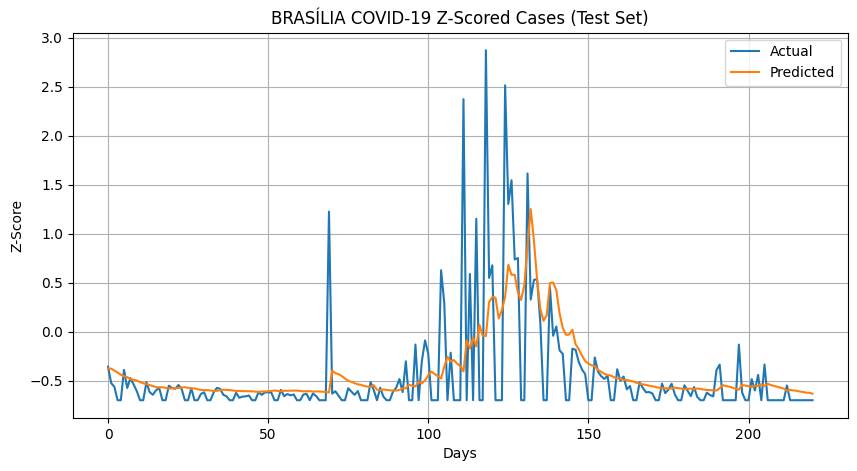

📉 RMSE for BRASÍLIA: 0.4518


In [29]:
import matplotlib.pyplot as plt
import networkx as nx

G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()  # [T, N]

# BRASÍLIA IBGE code
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)

sp_preds = pred_array[:, sp_index]
sp_actuals = actual_array[:, sp_index]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual')
plt.plot(sp_preds, label='Predicted')
plt.title("BRASÍLIA COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for BRASÍLIA: {rmse_sp:.4f}")



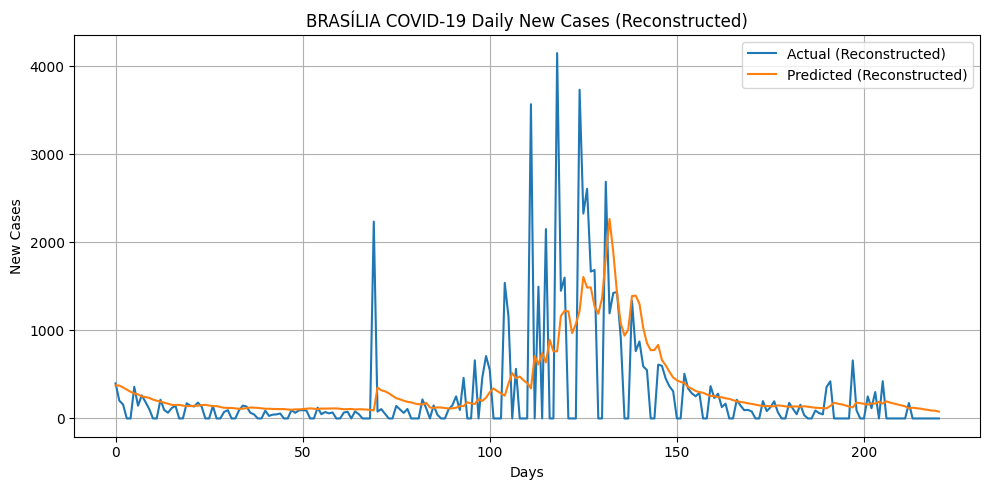

📉 RMSE for BRASÍLIA (Reconstructed): 524.88
📉 SMAPE for SP: 55.43%
📈 MDA for SP: 29.55%


In [30]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_id = int(row['Codmundv'])
    G2.add_node(city_id, name=row['nomemun'])

# Collapse last dimension
pred_array = predictions.squeeze(-1).numpy()  # [T, N]
actual_array = actuals.squeeze(-1).numpy()    # [T, N]

# BRASÍLIA IBGE code
sp_code = 5300108
city_id_list = list(G2.nodes())
sp_index = city_id_list.index(sp_code)


sp_preds_z = pred_array[:, sp_index]
sp_actuals_z = actual_array[:, sp_index]

# 🧠 Get mean and std from original covid_df
sp_original = covid_df[covid_df['ibgeID'] == sp_code].copy()
sp_original['newCases'] = sp_original['newCases'].clip(lower=0)
sp_original = sp_original.sort_values('date')
mean_sp = sp_original['newCases'].mean()
std_sp = sp_original['newCases'].std(ddof=0)

# 🔁 Reconstruct original values
sp_preds = sp_preds_z * std_sp + mean_sp
sp_actuals = sp_actuals_z * std_sp + mean_sp

# 📈 Plot reconstructed
plt.figure(figsize=(10, 5))
plt.plot(sp_actuals, label='Actual (Reconstructed)')
plt.plot(sp_preds, label='Predicted (Reconstructed)')
plt.title("BRASÍLIA COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("./figures/gcrn_brasilia_top_40.png", dpi=300)
plt.show()

# 📉 RMSE in original scale
rmse_sp = np.sqrt(mean_squared_error(sp_actuals, sp_preds))
print(f"📉 RMSE for BRASÍLIA (Reconstructed): {rmse_sp:.2f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
         np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )


def mean_directional_accuracy(actual, predicted):
    # Ensure arrays are 1D
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Compute directional changes
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare signs of differences
    correct_directions = (actual_diff * pred_diff) > 0

    # Compute MDA
    return 100 * np.mean(correct_directions)


smape_sp = smape(sp_actuals, sp_preds)
print(f"📉 SMAPE for SP: {smape_sp:.2f}%")

mda_sp = mean_directional_accuracy(sp_actuals, sp_preds)
print(f"📈 MDA for SP: {mda_sp:.2f}%")

In [31]:
# Filter BRASÍLIA full series
sp_full = filtered_scaled_covid_df[filtered_scaled_covid_df['ibgeID'] == sp_code].sort_values('date')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['date'].tolist()

In [33]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")

# Calculate SMAPE for each city
smapes = []
for i in range(num_cities):
    smape_i = smape(actual_array[:, i], pred_array[:, i])
    smapes.append(smape_i)

# Compute average SMAPE
avg_smape = np.mean(smapes)
print(f"📊 Average SMAPE across all cities: {avg_smape:.2f}%")

mdas = []
for i in range(num_cities):
    mda_i = mean_directional_accuracy(actual_array[:, i], pred_array[:, i])
    mdas.append(mda_i)

# Compute average MDA
avg_mda = np.mean(mdas)
print(f"📈 Average MDA across all cities: {avg_mda:.2f}%")


📊 Average RMSE across all cities: 0.6093
📊 Average SMAPE across all cities: 29.96%
📈 Average MDA across all cities: 24.77%


In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Map: city code → population
pop_dict = dict(zip(pop_df_filtered["ibgeID"], pop_df_filtered["population"]))

rmse_per_100k_list = []

print(len(backbone_cities))

for i, city_code in enumerate(backbone_cities):
    if city_code not in pop_dict:
        continue  # skip if population not found

    # Get predictions and labels (standardized)
    pred_z = pred_array[:, i]
    actual_z = actual_array[:, i]

    # Restore real case counts from z-score
    city_df = covid_df[covid_df['ibgeID'] == city_code].copy()
    city_df['newCases'] = city_df['newCases'].clip(lower=0).sort_values()

    mean_city = city_df['newCases'].mean()
    std_city = city_df['newCases'].std(ddof=0)

    pred_real = pred_z * std_city + mean_city
    actual_real = actual_z * std_city + mean_city

    # Convert to cases per 100k
    population = pop_dict[city_code]
    
    pred_per_100k = pred_real / population * 100000
    actual_per_100k = actual_real / population * 100000

    # Compute RMSE per 100k
    rmse = np.sqrt(mean_squared_error(actual_per_100k, pred_per_100k))
        
    rmse_per_100k_list.append(rmse)

# Average across all cities
avg_rmse_per_100k = np.mean(rmse_per_100k_list)
print(f"📉 Average RMSE per 100k population: {avg_rmse_per_100k:.2f}")


38
📉 Average RMSE per 100k population: 26.55


In [24]:
rmses_per_100k = []
pop_df = pd.read_csv("data/cleaned_population_2022.csv")

for i, city_id in enumerate(city_id_list):
    city_preds_z = pred_array[:, i]
    city_actuals_z = actual_array[:, i]
    
    # Get mean, std, and population
    city_data = covid_df[covid_df['ibgeID'] == city_id].copy()
    city_data['newCases'] = city_data['newCases'].clip(lower=0)
    mean = city_data['newCases'].mean()
    std = city_data['newCases'].std(ddof=0)
    
    pop = pop_df[pop_df['ibgeID'] == city_id]['population'].values
    if len(pop) == 0 or pd.isna(std) or std == 0:
        continue  # skip missing data or constant series
    
    population = pop[0]

    # Reconstruct actual values and normalize
    preds = city_preds_z * std + mean
    actuals = city_actuals_z * std + mean

    preds_per_100k = (preds / population) * 1e5
    actuals_per_100k = (actuals / population) * 1e5

    # RMSE per 100k
    rmse = np.sqrt(mean_squared_error(actuals_per_100k, preds_per_100k))
    rmses_per_100k.append(rmse)

avg_rmse_per_100k = np.mean(rmses_per_100k)
print(f"📊 Average RMSE across all cities (per 100k): {avg_rmse_per_100k:.4f}")


📊 Average RMSE across all cities (per 100k): 55.5812


In [25]:
city_rmse_pairs = list(zip(city_id_list, rmses))
sorted_city_rmses = sorted(city_rmse_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest RMSE:")
for city_id, rmse in sorted_city_rmses[-5:][::-1]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")

print("\n✅ Top 5 cities with lowest RMSE:")
for city_id, rmse in sorted_city_rmses[:5]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")



🔝 Top 5 cities with highest RMSE:
City ID: 2611606 — RMSE: 2.2327
City ID: 3118601 — RMSE: 1.9783
City ID: 4205407 — RMSE: 1.7435
City ID: 2211001 — RMSE: 1.3077
City ID: 3518800 — RMSE: 1.1290

✅ Top 5 cities with lowest RMSE:
City ID: 3534401 — RMSE: 0.0533
City ID: 2408102 — RMSE: 0.0702
City ID: 3543402 — RMSE: 0.1166
City ID: 3548708 — RMSE: 0.1582
City ID: 1501402 — RMSE: 0.1647


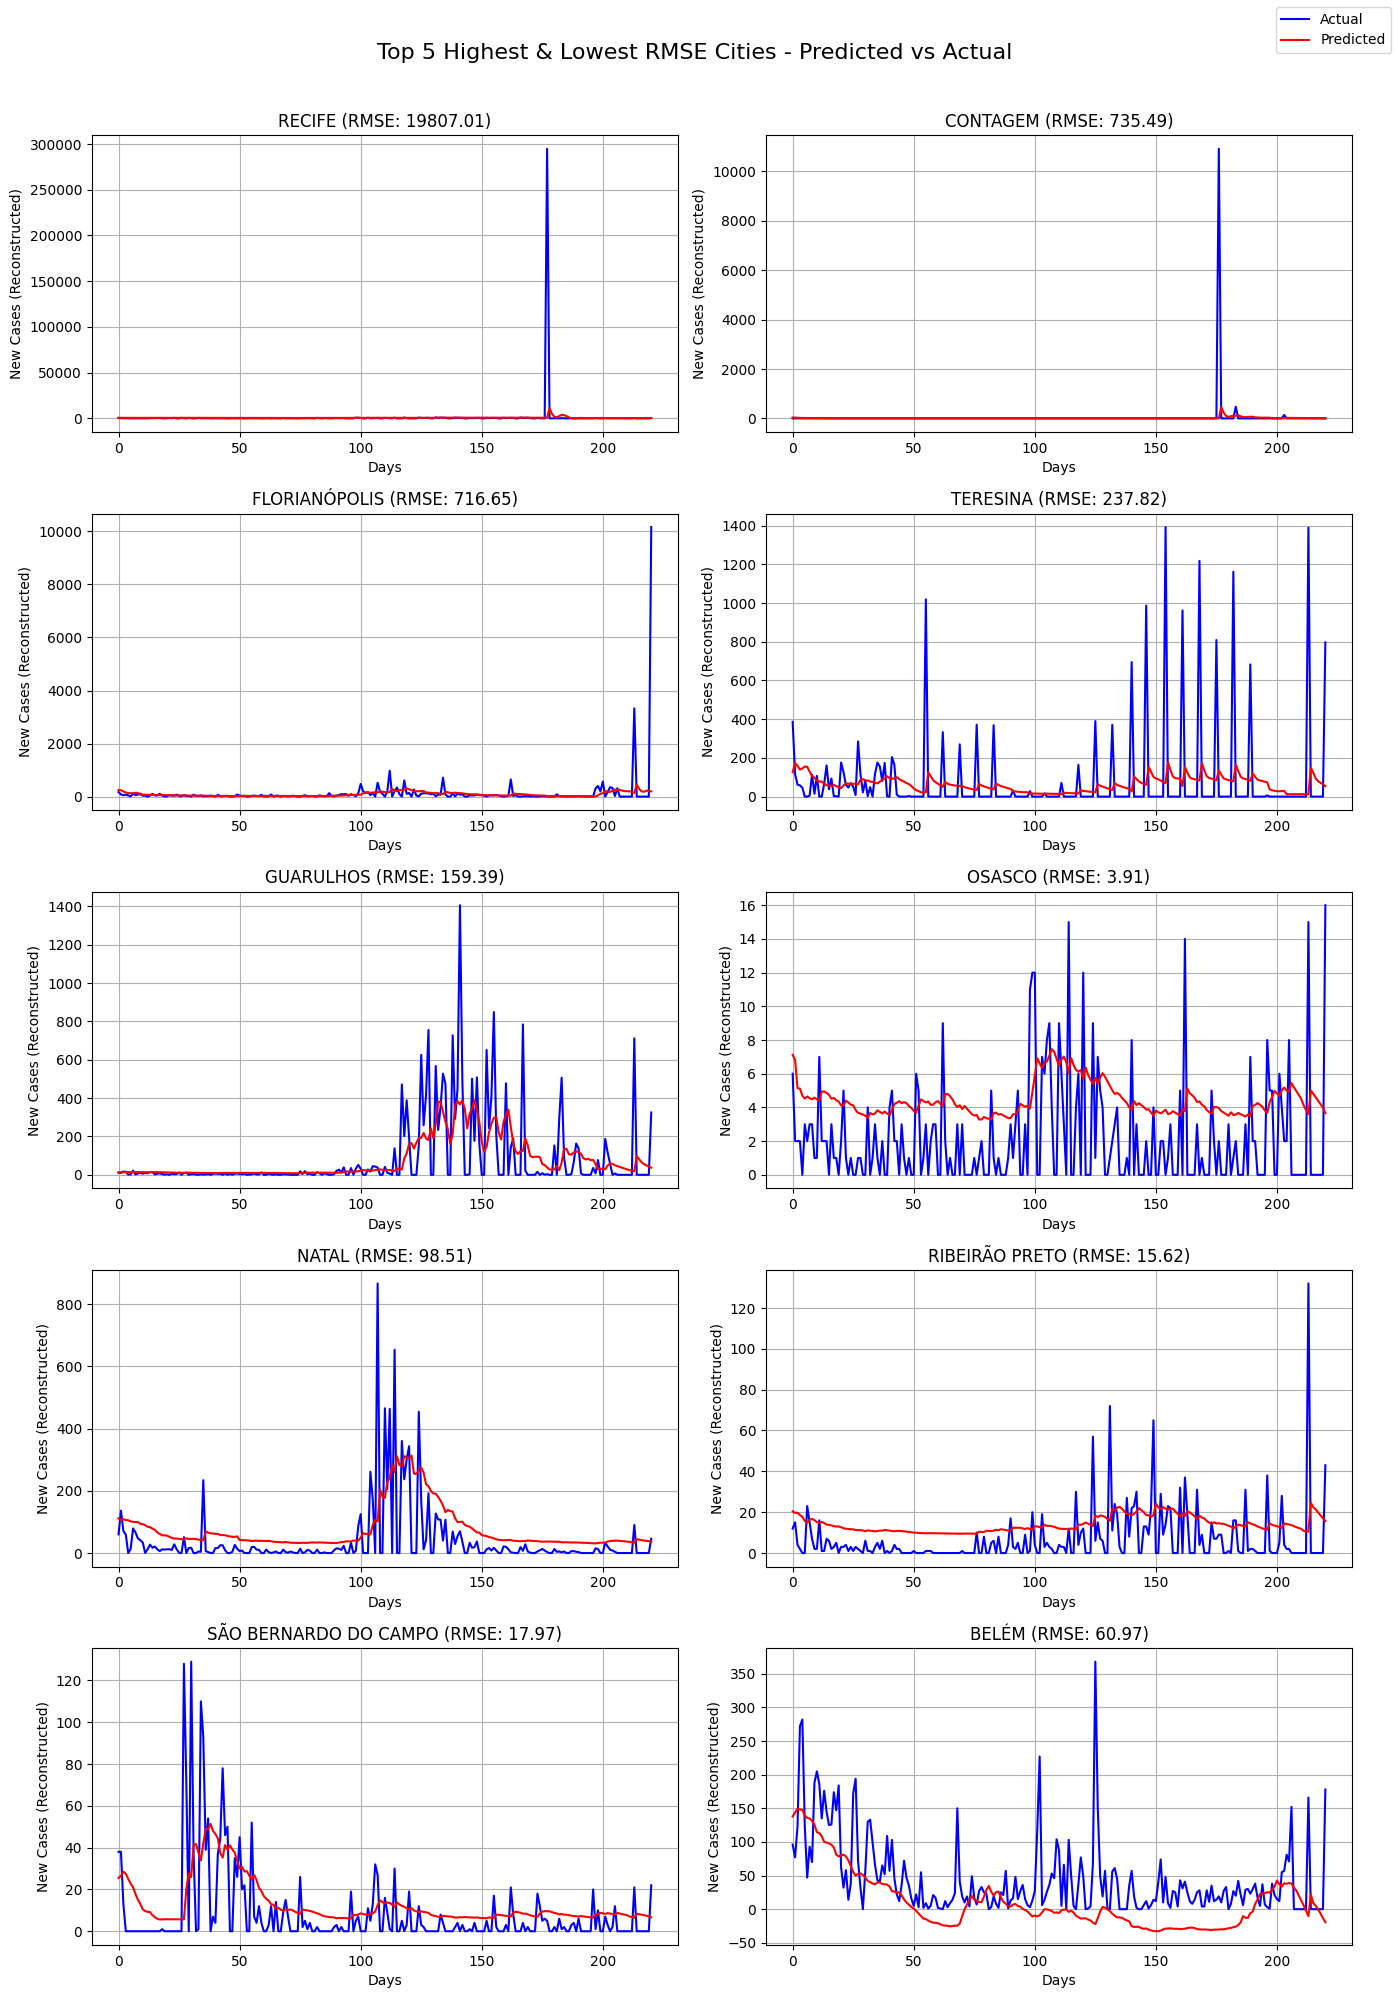

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = covid_df[covid_df['ibgeID'] == city_id].copy()
    city_data['newCases'] = city_data['newCases'].clip(lower=0)
    mean = city_data['newCases'].mean()
    std = city_data['newCases'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [24]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/Brazil-Experiment-Top-240-GCRN-Attempt-1.pth")